In [1]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scipy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import matplotlib

from scipy.stats import norm
 

In [4]:
## MOVING AVERAGE FOR FORECASTING

def moving_average(d, extra_periods=1, n=3):
    
    ## Historical Period Length
    cols = len(d)
    
    ## Append NaNs in Demand Array for future periods
    d = np.append(d, [np.nan]*extra_periods)
    
    ## Create the forecast Array
    f = np.full(cols+extra_periods, np.nan)
    
    ## Populate the forecasted values for demand values
    for t in range(n,cols):
        f[t] = round(np.mean(d[t-n:t]))
        
    ## Forecast for extra periods with same last forecasted values.
    f[t+1:] = np.mean(d[t-n+1:t+1])
        
    ## Returns Dataframe with Demand, Forecast and Error
    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Error':d-f})
    
    return df
    
## Notes
# np.nan is not a number is the initialized value. Initializing 0 or 1 will mis-lead.
# n.full will return an np array with dummy values.
    

In [5]:
## There are 3 variations developed from 1956 to 1960. First by R.G.Brown. Next Holt enhanced to add trends and
## lastly Winters added seasonality. The model is usually called Holt-Winters Model

def simple_exp_smooth(d, extra_periods = 1, alpha = 0.1):
    ## Demand Observations Length
    cols=len(d)
    
    ## Increase demand array to include extra periods of forecast
    d=np.append(d, [np.nan]*extra_periods)
    
    ## Create Forecast Column
    f=np.full(cols+extra_periods, np.nan)
    
    ## Initialize Forecast
    f[1] = d[0]
    
    ## Populate forecasts based on exponential smoothening of demand observations
    for t in range(2, cols+1):
        f[t] = alpha * d[t-1] + (1 - alpha) * f[t-1]
        
    ## Flatten the forecasts beyond the latest forecast
    for t in range(cols+1, cols+extra_periods):
        f[t] = f[t-1]
        
    df = pd.DataFrame({'Demand':d, 'Forecast':f, 'Error':d-f})
    
    return df


In [6]:
## Double Exponential Smoothening - Level and Trend

def double_exp_smooth(d, extra_periods = 1, alpha = 0.4, beta = 0.4):
    
    #To Save the demand observations 
    cols = len(d)
    
    # Extend Demand observations to accomodate forecast periods 
    d = np.append(d,[np.nan]*extra_periods)
    
    # Create Forecast column, Level and Trend
    f,lvl,trnd = np.full((3, cols+extra_periods), np.nan)
    
    ## Initialize Level and Trend
    lvl[0] = d[0]
    trnd[0] = d[1] - d[0]
    
    ## Create t+1 forecasts
    for t in range(1,cols):
        f[t] = lvl[t-1] + trnd[t-1]
        lvl[t] = alpha * d[t] + (1-alpha) * f[t]
        trnd[t] = beta * (lvl[t] - lvl[t-1]) + (1 - beta) * trnd[t-1]
        
    ## Forecast for future
    for t in range(cols, cols + extra_periods):
        f[t] = lvl[t-1] + trnd[t-1]
        lvl[t] = f[t]
        trnd[t] = trnd[t-1]
        
    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Level':lvl, 'Trend': trnd, 'Error':d-f})
    
    return df


In [7]:
## Double Exponential Smoothening - Damped

def double_exp_smooth_damped(d, extra_periods = 1, alpha = 0.4, beta = 0.4, phi = 0.8):
    
    #To Save the demand observations 
    cols = len(d)
    
    # Extend Demand observations to accomodate forecast periods 
    d = np.append(d,[np.nan]*extra_periods)
    
    # Create Forecast column, Level and Trend
    f,lvl,trnd = np.full((3, cols+extra_periods), np.nan)
    
    ## Initialize Level and Trend
    lvl[0] = d[0]
    trnd[0] = d[1] - d[0]
    
    ## Create t+1 forecasts
    for t in range(1,cols):
        f[t] = lvl[t-1] + phi * trnd[t-1]
        lvl[t] = alpha * d[t] + (1-alpha) * f[t]
        trnd[t] = beta * (lvl[t] - lvl[t-1]) + (1 - beta) * (phi * trnd[t-1])
        
    ## Forecast for future
    for t in range(cols, cols + extra_periods):
        f[t] = lvl[t-1] + phi* trnd[t-1]
        lvl[t] = f[t]
        trnd[t] = phi * trnd[t-1]
        
    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Level':lvl, 'Trend': trnd, 'Error':d-f})
    
    return df


In [8]:
## Initialization function for Seasons Cycle

def seasonal_factors_mul(s,d,slen, cols):
    for i in range(slen):
        s[i] = np.mean(d[i:cols:slen])
        
    s /= np.mean(s[:slen]) ## Normalize the means
    
    return s

In [9]:
def seasonal_factors_add(s,d,slen,cols):
    for i in range(slen):
        s[i] = np.mean(d[i:cols:slen])
        s -= np.mean(s[:slen])
        
    return s

In [10]:
def triple_exp_smooth_mul(d, slen = 12, extra_periods = 1, alpha = 0.4, beta = 0.4, phi = 0.9, gamma = 0.3):
    
    cols = len(d)
    d = np.append(d,[np.nan]*extra_periods)
    
    ## Create additional columns for forecast, level, trend and season
    f,a,b,s = np.full((4, cols+extra_periods), np.nan)
    
    ## Initializing Season
    s = seasonal_factors_mul(s, d, slen, cols)
    
    ## Initialize Level and Trend
    a[0] = d[0]/s[0]
    b[0] = d[1]/s[1] - d[0]/s[0]
    
    ## Create forecast for first seasonal cycle
    for t in range(1, slen):
        f[t] = (a[t-1] + phi * b[t-1]) * s[t]
        a[t] = alpha * d[t] / s[t] + (1-alpha) * (a[t-1] + phi * b[t-1])
        b[t] = beta * (a[t] - a[t-1]) + (1 - beta) * phi * b[t-1]
        
    
    ## Create forecast for next seasonal cycles for historical period
    
    for t in range(slen, cols):
        f[t] = (a[t-1] + phi * b[t-1]) * s[t - slen]
        a[t] = alpha * d[t] / s[t - slen] + (1-alpha) * (a[t-1] + phi * b[t-1])
        b[t] = beta * (a[t] - a[t-1]) + (1 - beta) * phi * b[t-1]
        s[t] = gamma * d[t]/a[t] + (1 - gamma) * s[t-slen]
        
    ## Forecast for future periods
    
    for t in range (cols, cols+ extra_periods):
        f[t] = (a[t-1] + phi * b[t-1]) * s[t - slen]
        a[t] = f[t]/s[t-slen]
        b[t] = phi * b[t-1]
        s[t] = s[t-slen]
        
        
    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Level':a, 'Trend':b, 'Season':s, 'Error':d-f})
    
    return df

In [11]:
def triple_exp_smooth_add(d, slen = 12, extra_periods = 1, alpha = 0.4, beta = 0.4, phi = 0.9, gamma = 0.3):
    
    cols = len(d)
    d = np.append(d,[np.nan]*extra_periods)
    
    ## Create additional columns for forecast, level, trend and season
    f,a,b,s = np.full((4, cols+extra_periods), np.nan)
    
    ## Initializing Season
    s = seasonal_factors_add(s, d, slen, cols)
    
    ## Initialize Level and Trend
    a[0] = d[0]-s[0]
    b[0] = (d[1]-s[1]) - (d[0]-s[0])
    
    ## Create forecast for first seasonal cycle
    for t in range(1, slen):
        f[t] = a[t-1] + phi * b[t-1] + s[t]
        a[t] = alpha * (d[t] - s[t]) + (1-alpha) * (a[t-1] + phi * b[t-1])
        b[t] = beta * (a[t] - a[t-1]) + (1 - beta) * phi * b[t-1]
        
    
    ## Create forecast for next seasonal cycles for historical period
    
    for t in range(slen, cols):
        f[t] = a[t-1] + phi * b[t-1] + s[t - slen]
        a[t] = alpha * (d[t] - s[t - slen]) + (1-alpha) * (a[t-1] + phi * b[t-1])
        b[t] = beta * (a[t] - a[t-1]) + (1 - beta) * phi * b[t-1]
        s[t] = gamma * (d[t]-a[t]) + (1 - gamma) * s[t-slen]
        
    ## Forecast for future periods
    
    for t in range (cols, cols+ extra_periods):
        f[t] = a[t-1] + phi * b[t-1] + s[t - slen]
        a[t] = f[t] - s[t-slen]
        b[t] = phi * b[t-1]
        s[t] = s[t-slen]
        
        
    df = pd.DataFrame.from_dict({'Demand':d, 'Forecast':f, 'Level':a, 'Trend':b, 'Season':s, 'Error':d-f})
    
    return df

In [12]:
## Optimization Function

def exp_smooth_opti_mae(d, extra_periods=6):
    
    params = [] #Set of model descriptions 
    KPIs = [] # Set of objective KPIs to be minized - MAE
    dfs = [] # Dataframes returned by different models
    
    for alpha in [0.05,0.1,0.2,0.3,0.4,0.5,0.6]:
        
        df = simple_exp_smooth(d, extra_periods = extra_periods, alpha=alpha)
        params.append(f'Simple Exponential Model with alpha = {alpha}')
        dfs.append(df)
        
        MAE = df['Error'].abs().mean()
        KPIs.append(MAE)
        
        for beta in [0.05,0.1,0.2,0.3,0.4]:
            
            df = double_exp_smooth(d,extra_periods = extra_periods, alpha=alpha, beta = beta)
            params.append(f'Double Exponential Smoothening Model with alpha = {alpha} and beta = {beta}')
            dfs.append(df)
            MAE = df['Error'].abs().mean()
            KPIs.append(MAE)
            
    
    mini = np.argmin(KPIs)
    
    print(f'Optimized Model is {params[mini]} with KPI(MAE) value {round(KPIs[mini],2)}')
          
    return dfs[mini]
          

In [13]:
## Optimization Function

def exp_smooth_opti_rmse(d, extra_periods=6):
    
    params = [] #Set of model descriptions 
    KPIs = [] # Set of objective KPIs to be minized - MAE
    dfs = [] # Dataframes returned by different models
    
    for alpha in [0.05,0.1,0.2,0.3,0.4,0.5,0.6]:
        
        df = simple_exp_smooth(d, extra_periods = extra_periods, alpha=alpha)
        params.append(f'Simple Exponential Model with alpha = {alpha}')
        dfs.append(df)
        
        RMSE = np.sqrt((df['Error']**2).mean())
        KPIs.append(RMSE)
        
        for beta in [0.05,0.1,0.2,0.3,0.4]:
            
            df = double_exp_smooth(d,extra_periods = extra_periods, alpha=alpha, beta = beta)
            params.append(f'Double Exponential Smoothening Model with alpha = {alpha} and beta = {beta}')
            dfs.append(df)
            RMSE = np.sqrt((df['Error']**2).mean())
            KPIs.append(RMSE)
            
    
    mini = np.argmin(KPIs)
    
    print(f'Optimized Model is {params[mini]} with KPI(RMSE) value {round(KPIs[mini],2)}')
          
    return dfs[mini]

In [14]:
## Function to calculate the KPIs - BIAS and ACCURACY. 

## Bias is different from accuracy. Bias indicates the undershoot or overshoot
## of Demand. The absolute value does not indicate accuracy as negative and positive values negate.

## Accuracy is expressed in terms of errors nullifying the negation effect by considering absolute or squared values

def kpi(df):
    ## Average Error indicated direction and hence Bias.
    bias_abs = df['Error'].mean()
    demand_select_avg = df.loc[df['Error'].notnull(), 'Demand'].mean()
    bias_rel = (bias_abs / demand_select_avg)
    
    print('Bias : Absolute is {:0.2f} and Relative to Demand is {:.2%}'.format(bias_abs,bias_rel))
    
    ## MAPE is scaled to demand
    MAPE = (df['Error'].abs()/df['Demand']).mean()
    print('MAPE: {:.2%}'.format(MAPE))
    print("MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats\n")
    
    ## MAE is not scaled to demand
    MAE_abs = (df['Error'].abs()).mean()
    MAE_rel = (MAE_abs/demand_select_avg)
    print('MAE: the Absolute is {:0.2f} and relative to demand is {:.2%}'.format(MAE_abs,MAE_rel))
    print("MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect\n")
    
    
    ## RMSE is scaled to Demand
    RMSE_abs =  np.sqrt((df['Error']**2).mean())
    RMSE_rel = RMSE_abs / demand_select_avg ## To normalize
    
    print("RMSE : Absolute value is {:0.2f} and relative to demand {:.2%}".format(RMSE_abs,RMSE_rel))
    print("However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax")
    print("MAE gives same importance to all error. But RMSE has other interesting properties")
    
    
    

In [15]:
## Functions to calculate commonly used forecast accuracy- MAPE Mean Absolute Percentage Error.
## However it gets skewed due the base effect.


In [16]:
## Common Test Data

d = [37,60,85,112,132,145,179,198,150,132]

In [17]:
## Using the Moving Average Function

ma_df = moving_average(d,extra_periods=4,n=3)
print(ma_df)


    Demand  Forecast  Error
0     37.0       NaN    NaN
1     60.0       NaN    NaN
2     85.0       NaN    NaN
3    112.0      61.0   51.0
4    132.0      86.0   46.0
5    145.0     110.0   35.0
6    179.0     130.0   49.0
7    198.0     152.0   46.0
8    150.0     174.0  -24.0
9    132.0     176.0  -44.0
10     NaN     160.0    NaN
11     NaN     160.0    NaN
12     NaN     160.0    NaN
13     NaN     160.0    NaN


<AxesSubplot:title={'center':'Moving Average'}>

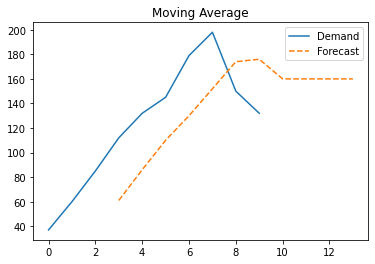

In [18]:
## Plot Demand vs Forecasted Values

ma_df[['Demand','Forecast']].plot(title='Moving Average', style=['-','--'])

In [19]:
## Notes
print("Observations of above graph :")
print("-----------------------------\n")
print("The future forecast line is flat. This indicates that trend or seasonality is not captured !")



Observations of above graph :
-----------------------------

The future forecast line is flat. This indicates that trend or seasonality is not captured !


In [20]:
print("UNDERSTANDING KPIs for Moving Averange\n")
kpi(ma_df)

UNDERSTANDING KPIs for Moving Averange

Bias : Absolute is 22.71 and Relative to Demand is 15.17%
MAPE: 29.21%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is 42.14 and relative to demand is 28.15%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is 43.05 and relative to demand 28.75%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


In [21]:
## REPORT ACCURACY KPIs for Exponential Smoothening

print("UNDERSTANDING KPIs for Exponential Smoothening\n")
es_df = simple_exp_smooth(d, 4, 0.4)
kpi(es_df)

UNDERSTANDING KPIs for Exponential Smoothening

Bias : Absolute is 30.89 and Relative to Demand is 23.31%
MAPE: 32.03%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is 40.25 and relative to demand is 30.36%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is 42.81 and relative to demand 32.29%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


<AxesSubplot:title={'center':'Simple Smoothening'}>

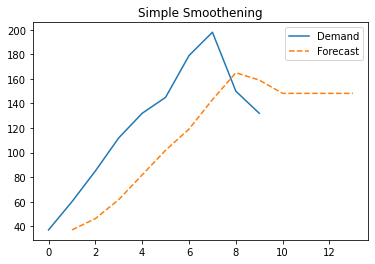

In [22]:
es_df[['Demand','Forecast']].plot(title='Simple Smoothening', style=['-','--'])

In [23]:
## REPORT ACCURACY KPIs for Double Exponential Smoothening
d= [28,19,18,13,19,16,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12]
print("UNDERSTANDING KPIs for Double Exponential Smoothening\n")
des_df = double_exp_smooth(d, extra_periods= 4)
kpi(des_df)

UNDERSTANDING KPIs for Double Exponential Smoothening

Bias : Absolute is 2.64 and Relative to Demand is 17.71%
MAPE: 28.14%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is 4.38 and relative to demand is 29.40%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is 6.26 and relative to demand 42.02%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


<AxesSubplot:title={'center':'Double Smoothening'}>

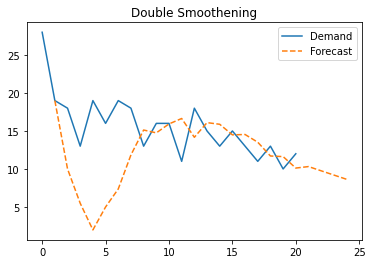

In [24]:
des_df[['Demand','Forecast']].plot(title='Double Smoothening', style=['-','--'])

In [25]:
## return the best model 
d= [28,19,18,13,19,16,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12]
print("The best Model based on MAE")
print("---------------------------\n")
mae_opt_df = exp_smooth_opti_mae(d, extra_periods= 6)
kpi(mae_opt_df)


The best Model based on MAE
---------------------------

Optimized Model is Simple Exponential Model with alpha = 0.4 with KPI(MAE) value 2.74
Bias : Absolute is -2.02 and Relative to Demand is -13.56%
MAPE: 19.25%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is 2.74 and relative to demand is 18.39%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is 3.89 and relative to demand 26.11%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


<AxesSubplot:title={'center':'Best MAE Model'}>

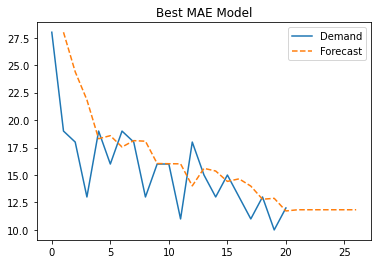

In [26]:
mae_opt_df[['Demand','Forecast']].plot(title='Best MAE Model', style=['-','--'])

In [27]:
## return the best model 
d= [28,19,18,13,19,16,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12]
print("The best Model based on RMSE")
print("---------------------------\n")
rmse_opt_df = exp_smooth_opti_rmse(d, extra_periods= 6)
kpi(rmse_opt_df)

The best Model based on RMSE
---------------------------

Optimized Model is Simple Exponential Model with alpha = 0.6 with KPI(RMSE) value 3.67
Bias : Absolute is -1.37 and Relative to Demand is -9.16%
MAPE: 19.74%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is 2.86 and relative to demand is 19.21%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is 3.67 and relative to demand 24.62%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


<AxesSubplot:title={'center':'Best RMSE Model'}>

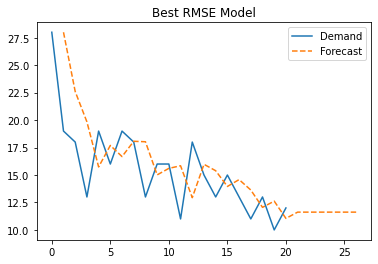

In [28]:
rmse_opt_df[['Demand','Forecast']].plot(title='Best RMSE Model', style=['-','--'])

In [29]:
## REPORT ACCURACY KPIs for Double Exponential Smoothening
d = [28,19,18,13,19,16,19,18,13,16,16,11,18,15,13,15,13,11,13,10,12]
print("UNDERSTANDING KPIs for Double Exponential Smoothening with Dampening\n")
des_dmp_df = double_exp_smooth_damped(d, extra_periods= 4)
kpi(des_dmp_df)

UNDERSTANDING KPIs for Double Exponential Smoothening with Dampening

Bias : Absolute is 0.87 and Relative to Demand is 5.81%
MAPE: 18.81%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is 2.83 and relative to demand is 19.01%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is 3.69 and relative to demand 24.78%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


<AxesSubplot:title={'center':'Double Smoothening With Damped'}>

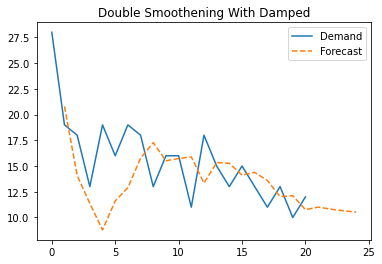

In [30]:
des_dmp_df[['Demand','Forecast']].plot(title='Double Smoothening With Damped', style=['-','--'])

In [31]:
## REPORT ACCURACY KPIs for Double Exponential Smoothening
d = [14,10, 6, 2, 18, 8,4,1,16,9,5,3,18,11,4,2,17,9,5,1]
print("UNDERSTANDING KPIs for Triple Exponential Multiplicative Smoothening with Dampening\n")
tes_dmp_df = triple_exp_smooth_mul(d, slen =12, extra_periods= 4, alpha = 0.3, beta = 0.2, phi = 0.9, gamma = 0.2)
kpi(tes_dmp_df)

UNDERSTANDING KPIs for Triple Exponential Multiplicative Smoothening with Dampening

Bias : Absolute is -0.19 and Relative to Demand is -2.39%
MAPE: 9.30%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is 0.64 and relative to demand is 8.12%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is 0.92 and relative to demand 11.74%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


<AxesSubplot:title={'center':'Triple Smoothening With Damped'}>

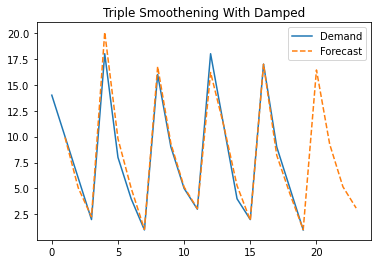

In [32]:
tes_dmp_df[['Demand','Forecast']].plot(title='Triple Smoothening With Damped', style=['-','--'])

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

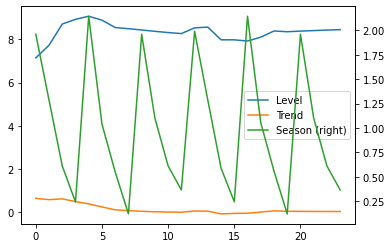

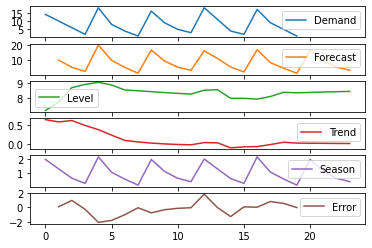

In [33]:
tes_dmp_df[['Level','Trend','Season']].plot(secondary_y=['Season'])
tes_dmp_df.plot(subplots = True)

In [34]:
## REPORT ACCURACY KPIs for Double Exponential Smoothening
d = [14,10, 6, 2, 18, 8,4,1,16,9,5,3,18,11,4,2,17,9,5,1]
print("UNDERSTANDING KPIs for Triple Exponential Additive Smoothening with Dampening\n")
tes_dmp_add_df = triple_exp_smooth_add(d, slen =12, extra_periods= 4, alpha = 0.3, beta = 0.2, phi = 0.9, gamma = 0.2)
kpi(tes_dmp_add_df)

UNDERSTANDING KPIs for Triple Exponential Additive Smoothening with Dampening

Bias : Absolute is nan and Relative to Demand is nan%
MAPE: nan%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is nan and relative to demand is nan%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is nan and relative to demand nan%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


In [35]:
## Outlier Detection

### Method 1 : Winsorization

higher_limit = np.percentile(d, 99)
lower_limit = np.percentile(d, 1)

d_wnsrd = np.clip(d,a_min=lower_limit, a_max = higher_limit)

print("UNDERSTANDING KPIs for Triple Exponential Smoothening with Dampening after winsorization\n")
tes_dmp_w_df = triple_exp_smooth_mul(d_wnsrd, slen =12, extra_periods= 4, alpha = 0.3, beta = 0.2, phi = 0.9, gamma = 0.2)
kpi(tes_dmp_w_df)


UNDERSTANDING KPIs for Triple Exponential Smoothening with Dampening after winsorization

Bias : Absolute is -0.19 and Relative to Demand is -2.39%
MAPE: 9.30%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is 0.64 and relative to demand is 8.12%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is 0.92 and relative to demand 11.74%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>], dtype=object)

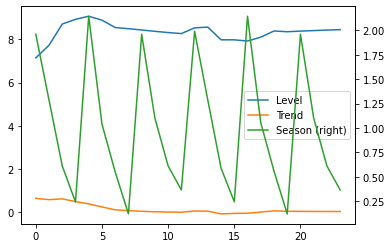

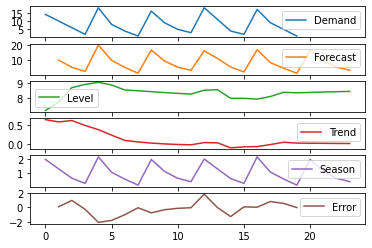

In [36]:
tes_dmp_w_df[['Level','Trend','Season']].plot(secondary_y=['Season'])
tes_dmp_w_df.plot(subplots = True)

In [37]:


print("UNDERSTANDING KPIs for Triple Exponential Smoothening with Dampening after Standardization\n")

m = tes_dmp_df.mean()
s = tes_dmp_df.std()

limit_high = norm.ppf(0.99, m,s)
lower_limit = norm.ppf(0.1, m ,s)

tes_dmp_s_df = tes_dmp_df.clip(lower = lower_limit , upper = limit_high, axis = 1)
kpi(tes_dmp_s_df)


UNDERSTANDING KPIs for Triple Exponential Smoothening with Dampening after Standardization

Bias : Absolute is -0.13 and Relative to Demand is -1.64%
MAPE: 8.82%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is 0.58 and relative to demand is 7.37%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is 0.81 and relative to demand 10.28%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


In [38]:
## Standardization is better than winsorization. However both methods might identify seasonal extreme values as outliers.

### Method 3 : Apply Standard Deviation on Forecast Errors.

m = tes_dmp_df['Error'].mean()
s = tes_dmp_df['Error'].std()

limit_high = norm.ppf(0.99,m,s) + tes_dmp_df['Forecast']
limit_low = norm.ppf(0.1,m,s) + tes_dmp_df['Forecast']

tes_dmp_e_df = tes_dmp_df.copy(deep = True)
tes_dmp_e_df['Demand'] = tes_dmp_e_df['Demand'].clip(lower = limit_low, upper = limit_high)
kpi(tes_dmp_e_df)


Bias : Absolute is -0.19 and Relative to Demand is -2.37%
MAPE: 9.22%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is 0.64 and relative to demand is 8.06%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is 0.92 and relative to demand 11.65%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


<AxesSubplot:title={'center':'Triple Smoothening With Error based Outliers'}>

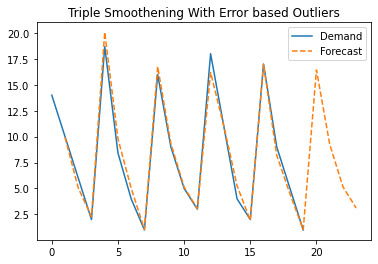

In [39]:
tes_dmp_e_df[['Demand','Forecast']].plot(title='Triple Smoothening With Error based Outliers', style=['-','--'])

In [40]:
### Above method 3 has slight error in error mean and error std as outlier errors are considered as well in error
### estimations. This needs to be eliminated before calculating the error mean and std

# Retrieve normalized values for Errors
prob = norm.cdf(tes_dmp_df['Error'],m,s)

outliers = (prob > 0.99) | (prob < 0.01)

m2 = tes_dmp_df.loc[~outliers, 'Error'].mean()
s2 = tes_dmp_df.loc[~outliers, 'Error'].std()

limit_high = norm.ppf(0.99,m,s) + tes_dmp_df['Forecast']
limit_low = norm.ppf(0.1,m,s) + tes_dmp_df['Forecast']

tes_dmp_ea_df = tes_dmp_df.copy(deep = True)

tes_dmp_ea_df['Demand'] = tes_dmp_ea_df['Demand'].clip(lower = limit_low, upper = limit_high)
kpi(tes_dmp_ea_df)


Bias : Absolute is -0.19 and Relative to Demand is -2.37%
MAPE: 9.22%
MAPE, though popular among demand forecasters, it is to be avoided. For high error with low demand it bloats

MAE: the Absolute is 0.64 and relative to demand is 8.06%
MAE is better than MAPE. Accounts for overall average demand and no impact of individual demand base effect

RMSE : Absolute value is 0.92 and relative to demand 11.65%
However RMSE gives imporatance to biggest error as its squaring. Very bad forecasting for one period might tax
MAE gives same importance to all error. But RMSE has other interesting properties


<AxesSubplot:title={'center':'Triple Smoothening With Error based Outliers'}>

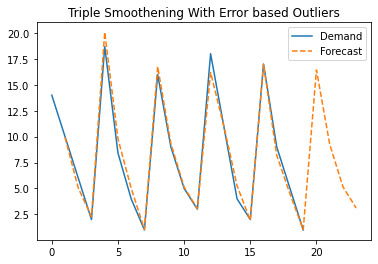

In [41]:
tes_dmp_ea_df[['Demand','Forecast']].plot(title='Triple Smoothening With Error based Outliers', style=['-','--'])